## License

Copyright 2021 - 2023 Patrick Hall (jphall@gwu.edu) and Carissa Paul (carissa.paul@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

*DISCLAIMER*: This notebook is not legal or compliance advice.

# Assignment 5 Template

#### Imports and inits

In [ ]:
!pip install interpret h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 962.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier      # interpret ebm class
from interpret.perf import ROC                                    # ROC measure for ebm
import numpy as np                                                # for basic array manipulation
import pandas as pd                                               # for dataframe manipulation
import time                                                       # for timers

# plotting functionality
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # necessary for custom legends

# display plots in notebook
%matplotlib inline

# set numpy random seed for better reproducibility
SEED = 12345
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
# may need to be updated to location on your drive
%cd drive/My\ Drive/DNSC_6330_Software/assignments/
%ls

Mounted at /content/drive/
/content/drive/My Drive/DNSC_6330_Software/assignments
assign_1_template.ipynb             ph_rem_ebm_2025_04_05_23_29_58.csv
assign_2_template.ipynb             ph_rem_ebm_2025_04_06_22_17_12.csv
assign_3_template.ipynb             ph_rem_ebm_2025_04_07_01_20_15.csv
assign_4_template.ipynb             stolen_dt.gv
assign_5_template.ipynb             stolen_dt.png
ph_rem_ebm_2025_04_05_05_40_35.csv  stolen_dt.zip


#### Start global timer

In [ ]:
tic = time.time()

#### Import data

In [ ]:
data = pd.read_csv('../data/hmda_train_preprocessed.csv')

#### Assign basic modeling roles

In [ ]:
y_name = 'high_priced'

## Fit interpretable model

#### Split data into train and validation partitions

In [ ]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Explainable Boosting Machine

#### Retrain most accurate model above 0.8 AIR to debug

In [ ]:
print(data.columns)


Index(['row_id', 'black', 'asian', 'white', 'amind', 'hipac', 'hispanic',
       'non_hispanic', 'male', 'female', 'agegte62', 'agelt62', 'term_360',
       'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std',
       'loan_to_value_ratio_std', 'no_intro_rate_period_std',
       'intro_rate_period_std', 'property_value_std', 'income_std',
       'debt_to_income_ratio_std', 'high_priced'],
      dtype='object')


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X = data.drop(columns='high_priced')
y = data['high_priced']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train EBM model
model = ExplainableBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
auc_original = roc_auc_score(y_test, y_pred)
print(f"Original ROC AUC: {auc_original:.4f}")




/usr/local/lib/python3.11/dist-packages/interpret/glassbox/_ebm/_ebm.py:812: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]
  warn(


Original ROC AUC: 0.8379


In [ ]:
'''# params dict for remediated models
rem_params = {'max_bins': 512,
              'max_interaction_bins': 16,
              'interactions': 10,
              'outer_bags': 4,
              'inner_bags': 0,
              'learning_rate': 0.001,
              'validation_size': 0.25,
              'min_samples_leaf': 5,
              'max_leaves': 5,
              'early_stopping_rounds': 100.0,
              'n_jobs': NTHREAD,
              'random_state': SEED} # YOUR REMEDIATED MODEL PARAMS HERE!

rem_x_names = ['property_value_std',
               'no_intro_rate_period_std',
               'loan_amount_std',
               'income_std',
               'conforming',
               'intro_rate_period_std',
               'debt_to_income_ratio_std',
               'term_360'] # YOUR REMEDIATED FEATURE LIST HERE!

# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])
rem_params['early_stopping_rounds'] = int(rem_params['early_stopping_rounds'])

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name])
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)'''

"# params dict for remediated models\nrem_params = {'max_bins': 512,\n              'max_interaction_bins': 16,\n              'interactions': 10,\n              'outer_bags': 4,\n              'inner_bags': 0,\n              'learning_rate': 0.001,\n              'validation_size': 0.25,\n              'min_samples_leaf': 5,\n              'max_leaves': 5,\n              'early_stopping_rounds': 100.0,\n              'n_jobs': NTHREAD,\n              'random_state': SEED} # YOUR REMEDIATED MODEL PARAMS HERE!\n\nrem_x_names = ['property_value_std',\n               'no_intro_rate_period_std',\n               'loan_amount_std',\n               'income_std',\n               'conforming',\n               'intro_rate_period_std',\n               'debt_to_income_ratio_std',\n               'term_360'] # YOUR REMEDIATED FEATURE LIST HERE!\n\n# reset some parameters to integers\nrem_params['random_state'] = int(rem_params['random_state'])\nrem_params['n_jobs'] = int(rem_params['n_jobs'])\nrem_

## Sensitivity Analysis: Stress Testing

#### Simulate recession conditions in validation data

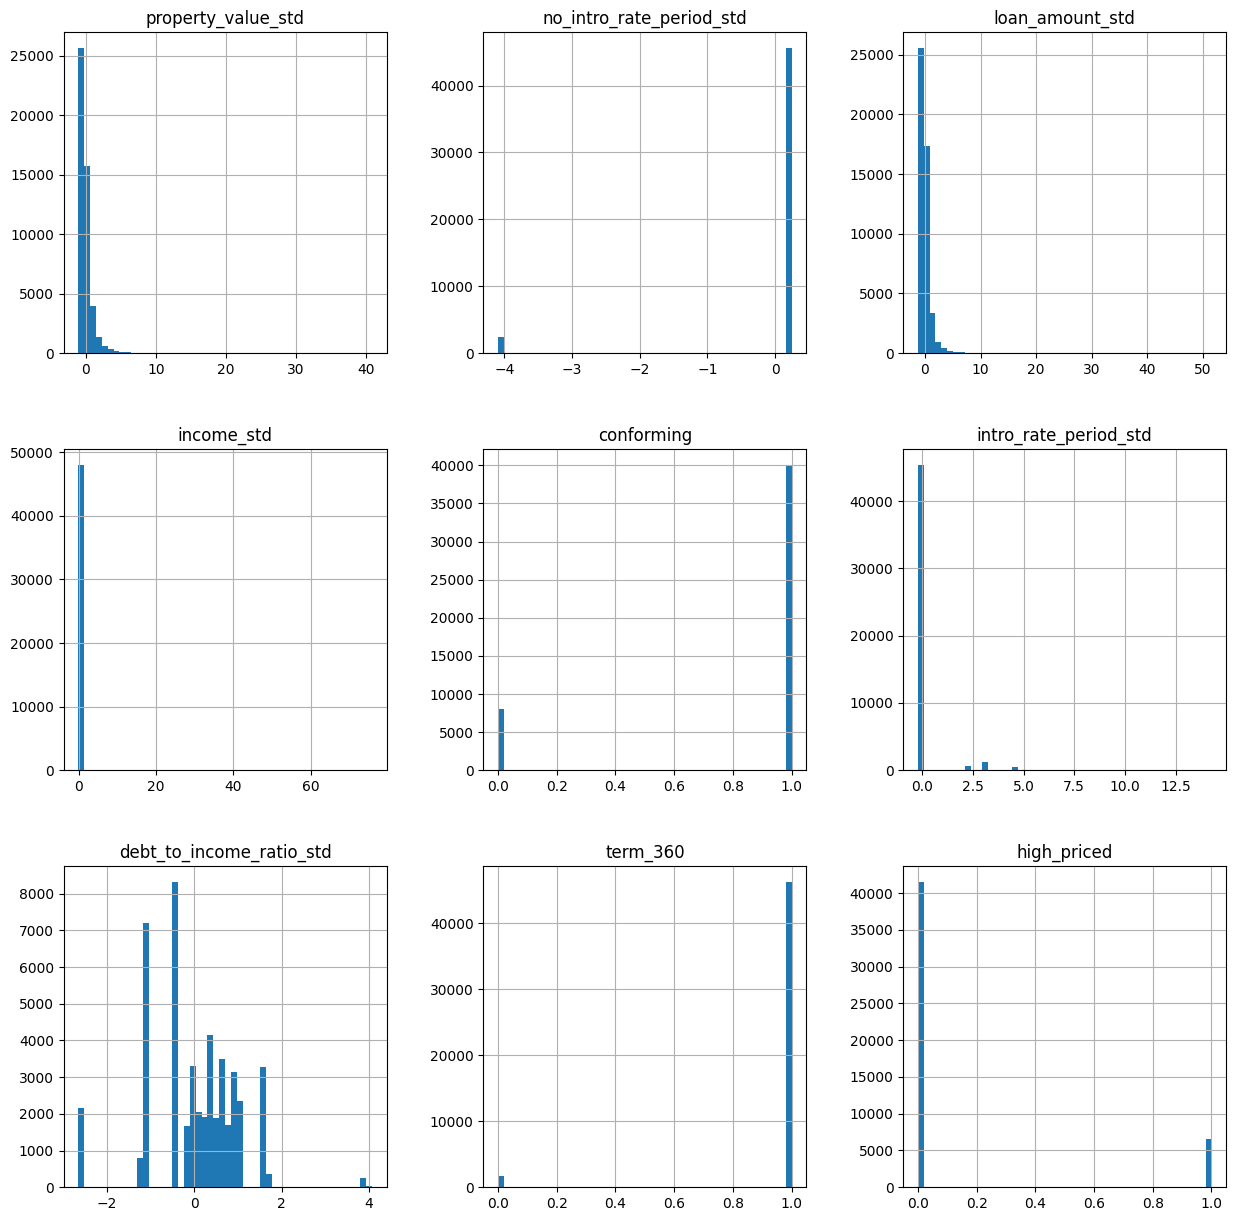

In [ ]:
np.random.seed(SEED) # set seed for this cell

rec_valid = valid.copy(deep=True) # deep copy of validation data

# use severity variable to control how many customers are affected
severity = 0.1
affected = np.random.rand(len(rec_valid)) < severity

# decrease property values by 5%
rec_valid.loc[affected, 'property_value_std'] = rec_valid.loc[affected, 'property_value_std'] * 0.95

# less intro rates
rec_valid.loc[affected, 'no_intro_rate_period_std'] = 0.2443944

# lower loan amounts by 5%
rec_valid.loc[affected, 'loan_amount_std'] = rec_valid.loc[affected, 'loan_amount_std'] * 0.95

# lower income by 5%
rec_valid.loc[affected, 'income_std'] = rec_valid.loc[affected, 'income_std'] * 0.95

# less conforming loans
rec_valid.loc[affected, 'conforming'] = 0

# shorter intro rate periods
rec_valid.loc[affected, 'intro_rate_period_std'] = rec_valid.loc[affected, 'intro_rate_period_std'] * 0.95

# 5% higher debt-to-income ratios
rec_valid.loc[affected, 'debt_to_income_ratio_std'] = rec_valid.loc[affected, 'debt_to_income_ratio_std'] * 1.05

# more long loans
rec_valid.loc[affected, 'term_360'] = 1

# update target
rec_valid.loc[affected, y_name] = np.random.choice(2, len(rec_valid.loc[affected, y_name]))

# visualize results
_ = rec_valid[rem_x_names + [y_name]].hist(bins=50, figsize=(15, 15))

#### Find AUC for best model in simulated recession conditions

In [ ]:
'''rec_rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(rec_valid[rem_x_names], rec_valid[y_name])
rec_rem_auc = rec_rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rec_rem_auc)'''

"rec_rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(rec_valid[rem_x_names], rec_valid[y_name])\nrec_rem_auc = rec_rem_ebm_perf._internal_obj['overall']['auc']\nprint('Remediated EBM retrained with AUC: %.4f.' % rec_rem_auc)"

In [ ]:
# Stress Test: Simulate recession conditions
X_test_recession = X_test.copy()
X_test_recession['debt_to_income_ratio_std'] *= 1.5
X_test_recession['income_std'] *= 0.7


y_pred_recession = model.predict_proba(X_test_recession)[:, 1]
auc_recession = roc_auc_score(y_test, y_pred_recession)
print(f"ROC AUC under recession conditions: {auc_recession:.4f}")

ROC AUC under recession conditions: 0.8286


Note the major drop in performance for recession conditions, which is normal for all models and usually worse for complex ML models. It's not unlikely that the more constrained monotonic GBM or penalized GLM could perform better in these conditions.

Also, this tells us we need to monitor this model carefully, because when recession conditions begin, this model will fail quickly.

## Residual Analysis

#### Calculate predictions and logloss residuals for all data

In [ ]:
'''# shortcut names
yhat_name = 'phat'
r_name = 'r'

# calculate predictions
rem_ebm_phat = pd.DataFrame(rem_ebm.predict_proba(data[rem_x_names])[:, 1], columns=['phat'])
rem_ebm_phat = pd.concat([data.reset_index(drop=True), rem_ebm_phat], axis=1)

# calculate logloss residuals
rem_ebm_phat[r_name] = -rem_ebm_phat[y_name]*np.log(rem_ebm_phat[yhat_name]) -\
                       (1 - rem_ebm_phat[y_name])*np.log(1 - rem_ebm_phat[yhat_name])'''

"# shortcut names\nyhat_name = 'phat'\nr_name = 'r'\n\n# calculate predictions\nrem_ebm_phat = pd.DataFrame(rem_ebm.predict_proba(data[rem_x_names])[:, 1], columns=['phat'])\nrem_ebm_phat = pd.concat([data.reset_index(drop=True), rem_ebm_phat], axis=1)\n\n# calculate logloss residuals\nrem_ebm_phat[r_name] = -rem_ebm_phat[y_name]*np.log(rem_ebm_phat[yhat_name]) -                       (1 - rem_ebm_phat[y_name])*np.log(1 - rem_ebm_phat[yhat_name])"

#### Plot residuals

In [ ]:
'''# initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))

# plot groups with appropriate color
color_list = ['royalblue', 'magenta']
c_idx = 0
groups = rem_ebm_phat.groupby(y_name) # define groups for levels of PAY_0
for name, group in groups:
    ax_.plot(group.phat, group.r,
             label=' '.join([y_name, str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1

# annotate plot
_ = plt.xlabel(yhat_name)
_ = plt.ylabel(r_name)
_ = ax_.legend(loc=1)
_ = plt.title('Global Logloss Residuals')'''

"# initialize figure\nfig, ax_ = plt.subplots(figsize=(8, 8))\n\n# plot groups with appropriate color\ncolor_list = ['royalblue', 'magenta']\nc_idx = 0\ngroups = rem_ebm_phat.groupby(y_name) # define groups for levels of PAY_0\nfor name, group in groups:\n    ax_.plot(group.phat, group.r,\n             label=' '.join([y_name, str(name)]),\n             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)\n    c_idx += 1\n\n# annotate plot\n_ = plt.xlabel(yhat_name)\n_ = plt.ylabel(r_name)\n_ = ax_.legend(loc=1)\n_ = plt.title('Global Logloss Residuals')"

Residuals are very unbalanced. This model struggles to predict when customers will recieve a high-priced loan correctly. It does much better when predicting customers will NOT receive a high-priced loan. There are also some very noticable outliers.

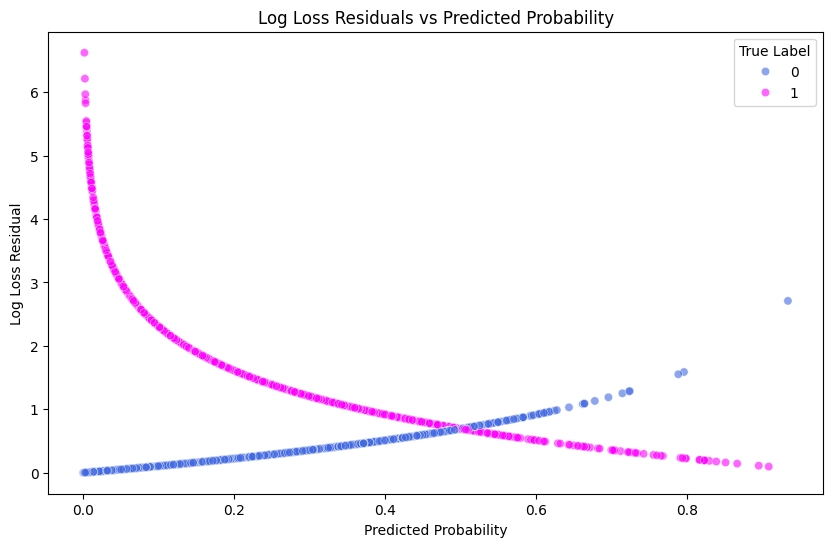

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Clip predictions to avoid log(0)
epsilon = 1e-15
y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)

# Compute log loss residuals
log_loss_residuals = -y_test * np.log(y_pred_clipped) - (1 - y_test) * np.log(1 - y_pred_clipped)

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=log_loss_residuals, hue=y_test, alpha=0.6, palette=['royalblue', 'magenta'])
plt.xlabel("Predicted Probability")
plt.ylabel("Log Loss Residual")
plt.title("Log Loss Residuals vs Predicted Probability")
plt.legend(title="True Label")
plt.show()


## Remediation: Remove Outliers

#### Find outliers

In [ ]:
rem_ebm_phat.sort_values(by='r', ascending=False).head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat,r
144991,144991,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,-0.382476,-1.782192,0.244394,-0.215304,0.389111,-0.052781,-1.156406,1,0.000631,7.368846
140987,140987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.514393,-2.001620,0.244394,-0.215304,0.358276,-0.033724,1.585876,1,0.000707,7.253973
66704,66704,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0.716833,0.302372,-4.091747,14.263178,0.389111,-0.012935,0.854601,1,0.000776,7.161407
82041,82041,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,-0.954117,-2.973067,0.244394,-0.215304,0.697459,-0.052781,-0.425131,1,0.000957,6.951625
31894,31894,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0.584916,-2.154007,0.244394,-0.215304,2.855893,0.068141,0.488963,1,0.001135,6.781224


In [ ]:
# Identify and remove outliers
outliers = residuals[abs(residuals) > 0.5].index
print(f"Number of outliers: {len(outliers)}")

Number of outliers: 3058


#### Remove worst outliers

In [ ]:
n_remove = 10
rem_data = data.copy(deep=True)
rem_data.drop(list(rem_ebm_phat.sort_values(by='r', ascending=False).head(n=n_remove).index), axis=0, inplace=True)

In [ ]:
X_train_clean = X_train.drop(outliers, errors='ignore')
y_train_clean = y_train.drop(outliers, errors='ignore')

## Remediation: Down-sample to Increase Signal from High-priced Loans

In [ ]:
inverse_proportion_remove = 2 # corresponds to keeping 1 - (1/inverse_proportion_remove) rows
rem_data.drop(list(rem_data[rem_data[y_name] == 0].index)[::inverse_proportion_remove], axis=0, inplace=True)

#### Retrain remediated EBM

In [ ]:
'''np.random.seed(SEED) # preserve exact reproducibility for this cell

# execute split
split = np.random.rand(len(rem_data)) < split_ratio
rem_train = rem_data[split]
rem_valid = rem_data[~split]

# summarize split
print('Remediated train data rows = %d, columns = %d' % (rem_train.shape[0], rem_train.shape[1]))
print('Remediated validation data rows = %d, columns = %d' % (rem_valid.shape[0], rem_valid.shape[1]))

# retrain
rem_ebm2 = ExplainableBoostingClassifier(**rem_params)
rem_ebm2.fit(rem_train[rem_x_names], rem_train[y_name])
rem_ebm_perf2 = ROC(rem_ebm2.predict_proba).explain_perf(rem_valid[rem_x_names], rem_valid[y_name])
rem_auc2 = rem_ebm_perf2._internal_obj['overall']['auc']
print('Remediated EBM under-sampled AUC: %.4f.' % rem_auc2)'''

"np.random.seed(SEED) # preserve exact reproducibility for this cell\n\n# execute split\nsplit = np.random.rand(len(rem_data)) < split_ratio\nrem_train = rem_data[split]\nrem_valid = rem_data[~split]\n\n# summarize split\nprint('Remediated train data rows = %d, columns = %d' % (rem_train.shape[0], rem_train.shape[1]))\nprint('Remediated validation data rows = %d, columns = %d' % (rem_valid.shape[0], rem_valid.shape[1]))\n\n# retrain\nrem_ebm2 = ExplainableBoostingClassifier(**rem_params)\nrem_ebm2.fit(rem_train[rem_x_names], rem_train[y_name])\nrem_ebm_perf2 = ROC(rem_ebm2.predict_proba).explain_perf(rem_valid[rem_x_names], rem_valid[y_name])\nrem_auc2 = rem_ebm_perf2._internal_obj['overall']['auc']\nprint('Remediated EBM under-sampled AUC: %.4f.' % rem_auc2)"

In [ ]:
# Retrain model after cleaning
model_clean = ExplainableBoostingClassifier()
model_clean.fit(X_train_clean, y_train_clean)
y_pred_clean = model_clean.predict_proba(X_test)[:, 1]
auc_clean = roc_auc_score(y_test, y_pred_clean)
print(f"ROC AUC after outlier removal: {auc_clean:.4f}")

/usr/local/lib/python3.11/dist-packages/interpret/glassbox/_ebm/_ebm.py:812: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]
  warn(


ROC AUC after outlier removal: 0.8379


#### Test remediated EBM on true validation data

In [ ]:
'''# calculate predictions
rem_ebm_phat2 = pd.DataFrame(rem_ebm.predict_proba(valid[rem_x_names])[:, 1], columns=['phat'])
rem_ebm_phat2 = pd.concat([valid.reset_index(drop=True), rem_ebm_phat2], axis=1)
rem_ebm_perf3 = ROC(rem_ebm2.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc3 = rem_ebm_perf3._internal_obj['overall']['auc']
print('Remediated EBM true AUC: %.4f.' % rem_auc3)'''

"# calculate predictions\nrem_ebm_phat2 = pd.DataFrame(rem_ebm.predict_proba(valid[rem_x_names])[:, 1], columns=['phat'])\nrem_ebm_phat2 = pd.concat([valid.reset_index(drop=True), rem_ebm_phat2], axis=1)\nrem_ebm_perf3 = ROC(rem_ebm2.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])\nrem_auc3 = rem_ebm_perf3._internal_obj['overall']['auc']\nprint('Remediated EBM true AUC: %.4f.' % rem_auc3)"

In [ ]:
y_val_pred = model_clean.predict_proba(X_train_clean)[:, 1]
auc_val = roc_auc_score(y_train_clean, y_val_pred)
print(f"ROC AUC on true validation set: {auc_val:.4f}")

ROC AUC on true validation set: 0.8448


Dropping outliers and under-sampling increases true AUC!

#### End global timer

In [ ]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 1338.72 s.
